# Noise Reduction with Spectral Subtraction


## Table of Contents

1. [Introduction](#introduction)
2. [Setup & Dependencies](#setup--dependencies)
3. [Configuration](#configuration)
4. [Helper Functions](#helper-functions)
5. [Load & Denoise](#load--denoise)
6. [Insert Dummy Data](#insert-dummy-data)
7. [Visualization](#visualization)
8. [Save Output](#save-output)
9. [Conclusion](#conclusion)

## 1. Introduction

In this notebook, we demonstrate a simple yet effective **spectral subtraction** method to reduce noise from audio recordings. We:

- Estimate a noise profile from a short segment of the noisy input.
- Subtract that noise spectrum from the full signal in the frequency domain.
- Reconstruct the denoised audio via inverse STFT.
- Replace the first 10 ms of the output waveform with dummy zeros to remove plotting artifacts.

This project is ideal for beginners in signal processing and machine learning who wish to explore basic audio denoising techniques.

## 2. Setup & Dependencies 

Make sure you have the following Python packages installed:

```bash
pip install numpy librosa soundfile matplotlib scipy

In [2]:
# Import required libraries
import os
import numpy as np  # numerical operations
# Fix compatibility for librosa on numpy >=1.24
np.complex = complex

import librosa        # audio I/O & processing
import librosa.display
import soundfile as sf  # reading/writing WAV files
import matplotlib.pyplot as plt
from scipy.signal import stft, istft  # STFT operations

print('Libraries imported successfully!')

Libraries imported successfully!


## 3. Configuration {#configuration}

Set up file paths and processing parameters:

In [3]:
# File paths
noisy_file = './noisy_sample.wav'
out_file   = './Demo/noisy_sample_denoised.wav'

# STFT parameters
frame_len, hop_len = 2048, 512

# Dummy data insertion
margin_ms = 10  # milliseconds to replace at start
sr = 44100      # sampling rate (Hz)
n_dummy = int(margin_ms * 1e-3 * sr)

print(f'Dummy samples at start: {n_dummy}')

Dummy samples at start: 441


## 4. Helper Functions {#helper-functions}

In [4]:
def extract_noise_profile(y, sr, duration=0.5):
    """
    Estimate an average magnitude spectrum from the first duration seconds of y.
    """
    n = int(sr * duration)
    noise = y[:n]
    _, _, Zxx = stft(noise, fs=sr, nperseg=frame_len,
                     noverlap=frame_len-hop_len, boundary=None)
    return np.mean(np.abs(Zxx), axis=1)


def spectral_subtract(y, sr, noise_spec):
    """
    Subtract noise_spec from the full signal in magnitude domain, then invert.
    """
    _, _, Zxx = stft(y, fs=sr, nperseg=frame_len,
                     noverlap=frame_len-hop_len, boundary=None)
    mag, phase = np.abs(Zxx), np.angle(Zxx)
    sub_mag = np.maximum(mag - noise_spec[:, None], 0.0)
    _, y_rec = istft(sub_mag * np.exp(1j * phase), fs=sr,
                     nperseg=frame_len, noverlap=frame_len-hop_len,
                     boundary=None)
    # Ensure same length
    y_rec = librosa.util.fix_length(y_rec, size=len(y))
    return y_rec

## 5. Load & Denoise {#load--denoise}


In [5]:
# Load noisy audio
y_noisy, sr = librosa.load(noisy_file, sr=None)
print(f"Loaded noisy audio: {noisy_file}, sr={sr}, duration={len(y_noisy)/sr:.2f}s")

# Estimate noise profile
noise_spec = extract_noise_profile(y_noisy, sr, duration=0.5)

# Apply spectral subtraction
y_denoised = spectral_subtract(y_noisy, sr, noise_spec)
print('Denoising complete!')

Loaded noisy audio: ./noisy_sample.wav, sr=48000, duration=9.30s
Denoising complete!


C:\Users\Aryan Gupta\AppData\Local\Temp\ipykernel_11148\4250752076.py:20: UserWarning: NOLA condition failed, STFT may not be invertible. Possibly due to missing boundary
  _, y_rec = istft(sub_mag * np.exp(1j * phase), fs=sr,


## 6. Insert Dummy Data {#insert-dummy-data}


In [6]:
# Overwrite first n_dummy samples with zeros
y_denoised[:n_dummy] = 0
print(f'First {n_dummy} samples replaced with zeros for plotting.')

First 441 samples replaced with zeros for plotting.


## 7. Visualization {#visualization}


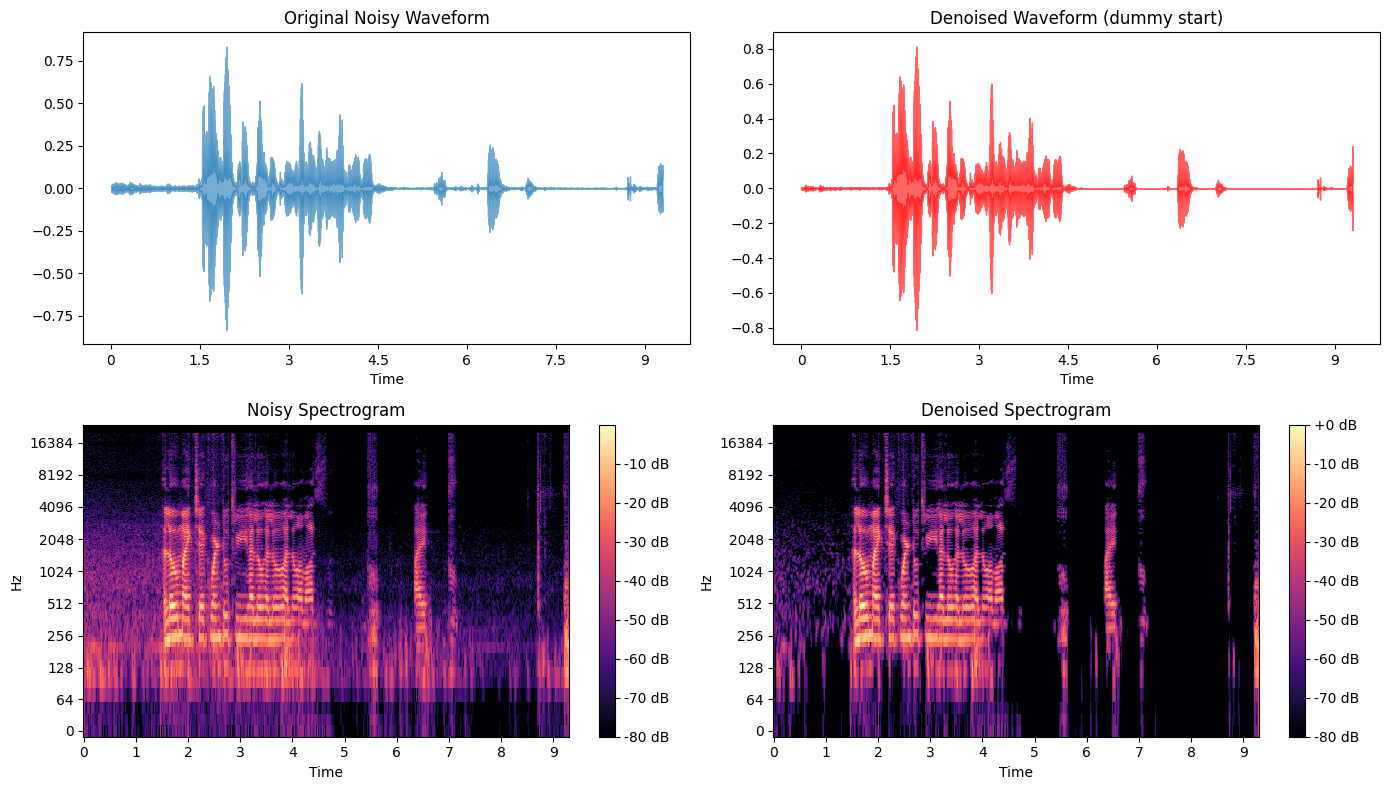

In [7]:
plt.figure(figsize=(14, 8))

# Waveforms
plt.subplot(2, 2, 1)
librosa.display.waveshow(y_noisy, sr=sr, alpha=0.6)
plt.title('Original Noisy Waveform')

plt.subplot(2, 2, 2)
librosa.display.waveshow(y_denoised, sr=sr, color='r', alpha=0.6)
plt.title('Denoised Waveform (dummy start)')

# Spectrograms
D_noisy = librosa.amplitude_to_db(np.abs(librosa.stft(y_noisy, n_fft=frame_len, hop_length=hop_len)), ref=np.max)
D_denoised = librosa.amplitude_to_db(np.abs(librosa.stft(y_denoised, n_fft=frame_len, hop_length=hop_len)), ref=np.max)

plt.subplot(2, 2, 3)
librosa.display.specshow(D_noisy, sr=sr, hop_length=hop_len, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Noisy Spectrogram')

plt.subplot(2, 2, 4)
librosa.display.specshow(D_denoised, sr=sr, hop_length=hop_len, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Denoised Spectrogram')

plt.tight_layout()
plt.show()

## 8. Save Output {#save-output}


In [8]:
# Create output directory
os.makedirs(os.path.dirname(out_file), exist_ok=True)

# Save denoised audio
sf.write(out_file, y_denoised, sr)
print(f"Denoised audio saved to: {out_file}")

Denoised audio saved to: ./Demo/noisy_sample_denoised.wav



## 9. Conclusion {#conclusion}

This notebook introduced a straightforward spectral subtraction pipeline for noise reduction.

**Next Steps:**

- Experiment with different noise durations for profile extraction.
- Tune STFT parameters (frame\_len, hop\_len).
- Explore advanced denoising methods such as Wiener filtering or deep learning models.

